# Time Series Forecasting with Prophet

This notebook implements time series forecasting using Facebook Prophet, with interactive visualizations using Plotly.

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

Importing matplotlib failed. Plotting will not work.


## Load and Prepare Data

In [2]:
# Load the cleaned data
df = pd.read_csv('../data/cleaned_superstore_sales.csv')

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Prepare daily sales data
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Rename columns to match Prophet requirements
daily_sales.columns = ['ds', 'y']

# Display the first few rows
daily_sales.head()

,ds,y
0,2015-01-03,16.448
1,2015-01-04,288.060
2,2015-01-05,19.536
3,2015-01-06,4407.100
4,2015-01-07,87.158


## Visualize Time Series Data

In [3]:
# Create time series plot
fig = px.line(daily_sales, x='ds', y='y', 
              title='Daily Sales Over Time',
              labels={'ds': 'Date', 'y': 'Sales'},
              template='plotly_white')

fig.update_layout(
    showlegend=False,
    hovermode='x unified'
)

fig.show()

## Train Prophet Model

In [4]:
# Initialize and train Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

model.fit(daily_sales)

09:01:30 - cmdstanpy - INFO - Chain [1] start processing
09:01:30 - cmdstanpy - INFO - Chain [1] done processing


## Make Future Predictions

In [5]:
# Create future dates dataframe
future_dates = model.make_future_dataframe(periods=90)  # Forecast next 90 days

# Make predictions
forecast = model.predict(future_dates)

# Create interactive plot with actual vs predicted values
fig = go.Figure()

# Add actual values
fig.add_trace(go.Scatter(
    x=daily_sales['ds'],
    y=daily_sales['y'],
    name='Actual Sales',
    mode='lines',
    line=dict(color='blue')
))

# Add predicted values
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    name='Predicted Sales',
    mode='lines',
    line=dict(color='red')
))

# Add confidence interval
fig.add_trace(go.Scatter(
    x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Confidence Interval'
))

fig.update_layout(
    title='Sales Forecast with Prophet',
    xaxis_title='Date',
    yaxis_title='Sales',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

## Analyze Components

In [6]:
# Get the components of the forecast
#components = model.plot_components(forecast)

# Create separate plots for each component using plotly
components_dict = {
    'Trend': forecast[['ds', 'trend']],
    'Yearly': forecast[['ds', 'yearly']],
    'Weekly': forecast[['ds', 'weekly']]
}

for component_name, data in components_dict.items():
    fig = px.line(data, x='ds', y=data.columns[1],
                  title=f'{component_name} Component',
                  labels={'ds': 'Date', data.columns[1]: 'Effect'},
                  template='plotly_white')
    
    fig.update_layout(showlegend=False)
    fig.show()

NameError: name 'plt' is not defined

## Model Evaluation

Mean Absolute Error: $1407.89
Root Mean Square Error: $2144.23
Mean Absolute Percentage Error: 780.87%


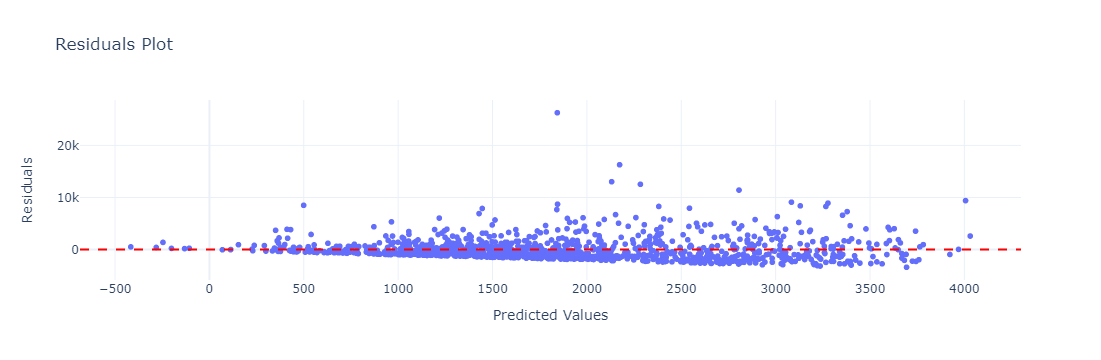

In [7]:
# Calculate error metrics
y_true = daily_sales['y'].values
y_pred = forecast[:len(y_true)]['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'Mean Absolute Error: ${mae:.2f}')
print(f'Root Mean Square Error: ${rmse:.2f}')
print(f'Mean Absolute Percentage Error: {mape:.2f}%')

# Create residuals plot
residuals = y_true - y_pred
fig = px.scatter(x=y_pred, y=residuals,
                title='Residuals Plot',
                labels={'x': 'Predicted Values', 'y': 'Residuals'},
                template='plotly_white')

fig.add_hline(y=0, line_dash='dash', line_color='red')
fig.show()